In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import join, isfile
from PIL import Image
import cv2
import fnmatch

In [7]:
cytoPath = '/Users/jbj7388/Library/CloudStorage/OneDrive-NorthwesternUniversity/ownProject/data/segmentationNPYfiles/scan2_WellA2/cyto'
nucleiPath = '/Users/jbj7388/Library/CloudStorage/OneDrive-NorthwesternUniversity/ownProject/data/segmentationNPYfiles/scan2_WellA2/nuclei'

In [8]:
cytoFolders = [x[0] for x in os.walk(cytoPath)]
cytoFolders = sorted(cytoFolders)

In [9]:
nucleiFolders= [x[0] for x in os.walk(nucleiPath)]
nucleiFolders = sorted(nucleiFolders)

In [10]:
cytoFolders

['/Users/jbj7388/Library/CloudStorage/OneDrive-NorthwesternUniversity/ownProject/data/segmentationNPYfiles/scan2_WellA2/cyto',
 '/Users/jbj7388/Library/CloudStorage/OneDrive-NorthwesternUniversity/ownProject/data/segmentationNPYfiles/scan2_WellA2/cyto/mergedDAPIYFPNormalized_Subregion_100_r10_c10',
 '/Users/jbj7388/Library/CloudStorage/OneDrive-NorthwesternUniversity/ownProject/data/segmentationNPYfiles/scan2_WellA2/cyto/mergedDAPIYFPNormalized_Subregion_10_r1_c10',
 '/Users/jbj7388/Library/CloudStorage/OneDrive-NorthwesternUniversity/ownProject/data/segmentationNPYfiles/scan2_WellA2/cyto/mergedDAPIYFPNormalized_Subregion_11_r2_c1',
 '/Users/jbj7388/Library/CloudStorage/OneDrive-NorthwesternUniversity/ownProject/data/segmentationNPYfiles/scan2_WellA2/cyto/mergedDAPIYFPNormalized_Subregion_12_r2_c2',
 '/Users/jbj7388/Library/CloudStorage/OneDrive-NorthwesternUniversity/ownProject/data/segmentationNPYfiles/scan2_WellA2/cyto/mergedDAPIYFPNormalized_Subregion_13_r2_c3',
 '/Users/jbj7388/Li

In [28]:
lengthsCyto = []
lengthsNuclei = []
lengthCytoImage = 700
lengthNucleiImage = 150

#for r in range(3,11):
r=2
for c in range(3,11):
    if (r != 0) & (c!=0):
        #Find the corresponding cytoplasm and nucleiFile
        pattern = "*r" + str(r) +"_c" + str(c)
        cytoFolder = fnmatch.filter(cytoFolders, pattern)
        nucleiFolder = fnmatch.filter(nucleiFolders, pattern)

        #Load the the cyto and nuclei File
        os.chdir(cytoFolder[0])
        files = [f for f in listdir(cytoFolder[0]) if isfile(join(cytoFolder[0], f))]
        cytoDatafolder = [np.load(f, allow_pickle=True).item() for f in files ]
        os.chdir(nucleiFolder[0])
        files = [f for f in listdir(nucleiFolder[0]) if isfile(join(nucleiFolder[0], f))]
        nucleiDatafolder = [np.load(f, allow_pickle=True).item() for f in files ]

        for i in range(len(cytoDatafolder)):
            #Convert the data into mask array and calculate unique masks
            data = cytoDatafolder[i]
            cytoMasks = data['masks']
            cytoValues = np.unique(cytoMasks)
            data = nucleiDatafolder[i]
            nucleiMasks = data['masks']
            nucleiValues = np.unique(nucleiMasks)

            #define border values, which should be excluded
            minCoord = np.arange(10)
            maxCoordy = np.arange(cytoMasks.shape[0] - 11, cytoMasks.shape[0])
            maxCoordx = np.arange(cytoMasks.shape[1] - 11, cytoMasks.shape[1])

            #loop over every mask to check if cytoplasm has only one nuclei and if nuclei is fully in cytoplasm
            for j in cytoValues:
                if j!= 0:
                    #check if only one nuclei is in cytoplasm
                    cytoMask = np.where(cytoMasks == j)
                    nucleiInCyto = np.unique(nucleiMasks[cytoMask[0], cytoMask[1]])
                    if len(nucleiInCyto[nucleiInCyto != 0]) == 1:
                        nucleiID = nucleiInCyto[nucleiInCyto != 0][0]
                        nucleiMask = np.where(nucleiMasks == nucleiID)
                        if len(np.unique(cytoMasks[nucleiMask[0], nucleiMask[1]])) == 1:
                            fullImageCyto = np.zeros((lengthCytoImage, lengthCytoImage), dtype= 'uint8')
                            fullImageNuclei = np.zeros((lengthNucleiImage, lengthNucleiImage), dtype= 'uint8')

                            xminCyto, yminCyto = cytoMask[1].min(), cytoMask[0].min()
                            xmaxCyto, ymaxCyto = cytoMask[1].max(), cytoMask[0].max()

                            xminNuclei, yminNuclei = nucleiMask[1].min(), nucleiMask[0].min()
                            xmaxNuclei, ymaxNuclei = nucleiMask[1].max(), nucleiMask[0].max()

                            #check if nuclei/cyto not at borders
                            if (xminCyto not in minCoord) & (yminCyto not in minCoord) & (xmaxCyto not in maxCoordx) & (ymaxCyto not in maxCoordy) & (xminNuclei not in minCoord) & (yminNuclei not in minCoord) & (xmaxNuclei not in maxCoordx) & (ymaxNuclei not in maxCoordy):
                                #keeping track of cytoplasm length
                                if ((xmaxCyto -xminCyto) >= (ymaxCyto -yminCyto)):
                                    lengthsCyto.append((xmaxCyto -xminCyto))
                                else:
                                    lengthsCyto.append((ymaxCyto -yminCyto))

                                #keeping track of nuclei length
                                if ((xmaxNuclei -xminNuclei) >= (ymaxNuclei -yminNuclei)):
                                    lengthsNuclei.append((xmaxNuclei -xminNuclei))
                                else:
                                    lengthsNuclei.append((ymaxNuclei -yminNuclei))

                                #check if nuclei/cyto not too large and not at borders
                                if  ((xmaxCyto -xminCyto) <= lengthCytoImage) & ((ymaxCyto -yminCyto) <= lengthCytoImage) & ((xmaxNuclei -xminNuclei) <= lengthNucleiImage) & ((ymaxNuclei -yminNuclei) <= lengthNucleiImage):

                                    #extract cytoplasm and nuclei
                                    cellImage = cytoMasks[yminCyto:ymaxCyto, xminCyto:xmaxCyto].copy()
                                    cellImage[cellImage != j] = 0
                                    cellImage[cellImage == j] = 255
                                    cellImage = np.asarray(cellImage, dtype = 'uint8')

                                    nucleiImage = nucleiMasks[yminNuclei:ymaxNuclei, xminNuclei:xmaxNuclei].copy()
                                    nucleiImage[nucleiImage != nucleiID] = 0
                                    nucleiImage[nucleiImage == nucleiID] = 255
                                    nucleiImage = np.asarray(nucleiImage, dtype = 'uint8')

                                    #put cytoplasm and nuclei in the middle of the image
                                    xshiftCyto, yshiftCyto = int((lengthCytoImage - xmaxCyto + xminCyto)/2), int((lengthCytoImage - ymaxCyto + yminCyto)/2)
                                    xshiftNuclei, yshiftNuclei = int((lengthNucleiImage - xmaxNuclei + xminNuclei)/2), int((lengthNucleiImage - ymaxNuclei + yminNuclei)/2)
                                    fullImageCyto[yshiftCyto:yshiftCyto + ymaxCyto - yminCyto, xshiftCyto: xshiftCyto + xmaxCyto - xminCyto] = cellImage
                                    fullImageNuclei[yshiftNuclei:yshiftNuclei + ymaxNuclei - yminNuclei, xshiftNuclei: xshiftNuclei + xmaxNuclei - xminNuclei] = nucleiImage

                                    #save cyto and nuclei as image
                                    imCyto = Image.fromarray(fullImageCyto)
                                    imNuclei = Image.fromarray(fullImageNuclei)
                                    filenameNuclei =  'Nuclei150_Scan2_WellA2_r' + str(r) + '_c' + str(c) + '_n' + str(j) + '.png'
                                    filenameCyto =  'Cyto700_Scan2_WellA2_r' + str(r) + '_c' + str(c) + '_n' + str(j) + '.png'
                                    os.chdir('/Users/jbj7388/coding/ownProject/singleCellImage/scan1_WellA1/cyto')
                                    imCyto.save(filenameCyto)
                                    os.chdir('/Users/jbj7388/coding/ownProject/singleCellImage/scan1_WellA1/nuclei')
                                    imNuclei.save(filenameNuclei)

(array([9.0000e+00, 2.1700e+02, 1.1075e+04, 4.8240e+03, 4.3500e+02,
        8.8000e+01, 2.5000e+01, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 13. ,  25.6,  38.2,  50.8,  63.4,  76. ,  88.6, 101.2, 113.8,
        126.4, 139. ]),
 <BarContainer object of 10 artists>)

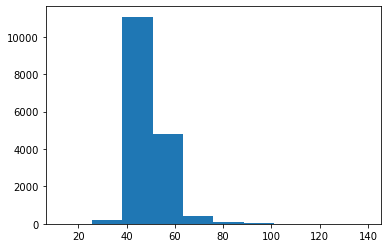

In [19]:
#until r2,c2
plt.hist(lengthsNuclei)

(array([2.6000e+01, 1.8200e+02, 4.1728e+04, 3.8755e+04, 4.4580e+03,
        8.4500e+02, 2.1900e+02, 5.2000e+01, 1.0000e+01, 5.0000e+00]),
 array([ 10. ,  22.9,  35.8,  48.7,  61.6,  74.5,  87.4, 100.3, 113.2,
        126.1, 139. ]),
 <BarContainer object of 10 artists>)

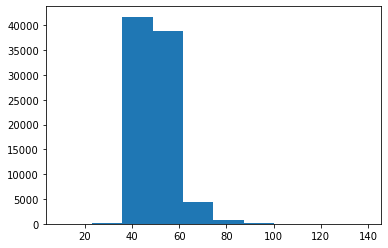

In [22]:
plt.hist(lengthsNuclei)

(array([3.000e+00, 5.000e+00, 1.456e+03, 6.841e+03, 1.684e+03, 2.510e+02,
        4.700e+01, 1.300e+01, 6.000e+00, 2.000e+00]),
 array([  9. ,  20.4,  31.8,  43.2,  54.6,  66. ,  77.4,  88.8, 100.2,
        111.6, 123. ]),
 <BarContainer object of 10 artists>)

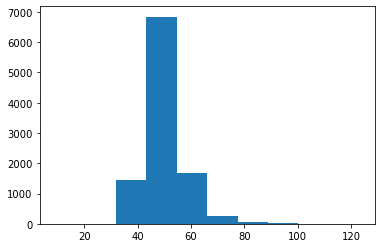

In [29]:
#r2,3-10
plt.hist(lengthsNuclei)

(array([6.630e+03, 6.408e+03, 2.718e+03, 7.020e+02, 1.810e+02, 2.900e+01,
        7.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([ 47. , 102.5, 158. , 213.5, 269. , 324.5, 380. , 435.5, 491. ,
        546.5, 602. ]),
 <BarContainer object of 10 artists>)

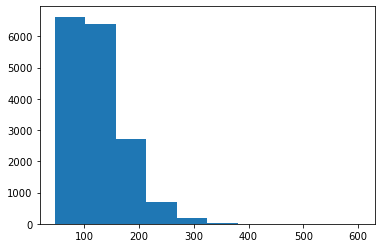

In [20]:
#until r2,c2
plt.hist(lengthsCyto)-

(array([1.9893e+04, 4.0422e+04, 1.9426e+04, 5.1910e+03, 1.0610e+03,
        2.2700e+02, 4.9000e+01, 9.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 31. ,  92.9, 154.8, 216.7, 278.6, 340.5, 402.4, 464.3, 526.2,
        588.1, 650. ]),
 <BarContainer object of 10 artists>)

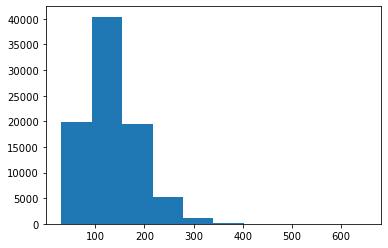

In [23]:
plt.hist(lengthsCyto)

(array([1.628e+03, 4.012e+03, 2.686e+03, 1.214e+03, 5.100e+02, 1.820e+02,
        6.000e+01, 1.000e+01, 3.000e+00, 3.000e+00]),
 array([ 39. ,  81.5, 124. , 166.5, 209. , 251.5, 294. , 336.5, 379. ,
        421.5, 464. ]),
 <BarContainer object of 10 artists>)

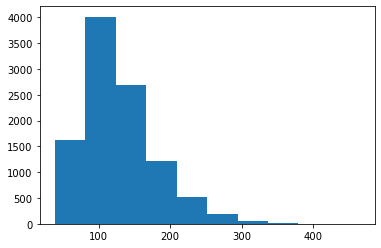

In [30]:
#r2,3-10
plt.hist(lengthsCyto)